<a href="https://colab.research.google.com/github/p-ai-org/p-deepfake/blob/main/videos_to_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
'''
with open('/content/drive/My Drive/P-Deepfake/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')
!cat /content/drive/My\ Drive/P-Deepfake/foo.txt
'''

"\nwith open('/content/drive/My Drive/P-Deepfake/foo.txt', 'w') as f:\n  f.write('Hello Google Drive!')\n!cat /content/drive/My\\ Drive/P-Deepfake/foo.txt\n"

imports below


In [ ]:
import json
import os
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

# Database Creation Code


In [ ]:
metadata_file = "/content/drive/My Drive/P-Deepfake/sample_videos/metadata.json"
input_path = "/content/drive/My Drive/P-Deepfake/sample_videos"
frame_save_path = "/content/drive/My Drive/P-Deepfake/output_images"

STRIDE = 1.0
MAX_IMAGE_SIZE = 1024


In [ ]:
def get_frames_from_video(video_file, stride=1.0):
    """
    video_file - path to file
    stride - i.e 1.0 - extract frame every second, 0.5 - extract every 0.5 seconds
    return: list of images, list of frame times in seconds
    """
    video = cv2.VideoCapture(video_file)
    fps = video.get(cv2.CAP_PROP_FPS)
    i = 0.
    images = []
    frame_times = []

    while video.isOpened():
        ret, frame = video.read()
        if ret:
            images.append(frame)
            frame_times.append(i)
            i += stride
            video.set(1, round(i * fps))
        else:
            video.release()
            break
    return images, frame_times


def resize_if_necessary(image, max_size=1024):
    """
    if any spatial shape of image is greater 
    than max_size, resize image such that max. spatial shape = max_size,
    otherwise return original image
    """
    if max_size is None:
        return image
    height, width = image.shape[:2]
    if max([height, width]) > max_size:
        ratio = float(max_size / max([height, width]))
        image = cv2.resize(image, (0, 0), fx=ratio, fy=ratio, interpolation=cv2.INTER_CUBIC)
    return image

In [ ]:
with open(metadata_file) as json_file:
    metadata = json.load(json_file)

key = list(metadata.keys())[0]
sample_video = os.path.join(input_path, key)

images, frame_times = get_frames_from_video(sample_video, STRIDE)
images = [resize_if_necessary(image, MAX_IMAGE_SIZE) for image in images]

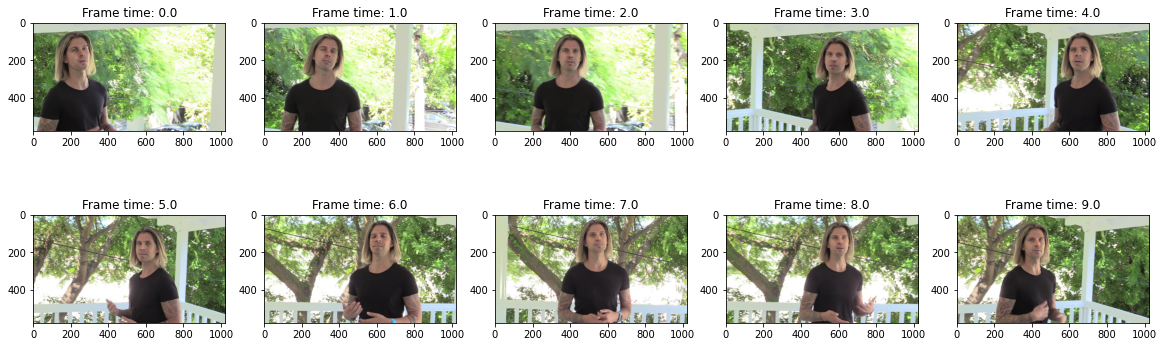

In [ ]:
plt.figure(figsize=(20,10))
columns = 5
for i, (image, frame_time) in enumerate(zip(images, frame_times)):
    plt.subplot(len(images) / columns + 1, columns, i + 1).set_title("Frame time: " + str(frame_time))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [ ]:
def process_video(input_path, save_path, key, stride, max_image_size):
    video_file = os.path.join(input_path, key)
    images, frame_times = get_frames_from_video(video_file, stride)
    images = [resize_if_necessary(image, max_image_size) for image in images]
    file_name, _ = key.split(".")
    if not os.path.isdir(os.path.join(save_path, file_name)):
        os.makedirs(os.path.join(save_path, file_name))
    for image, frame_time in zip(images, frame_times):
        image_name = str(round(frame_time, 3)).replace(".", "_")
        cv2.imwrite(os.path.join(save_path, file_name, "{}.jpg".format(image_name)), image)    
    

In [ ]:
process_video(input_path, frame_save_path, key, STRIDE, MAX_IMAGE_SIZE)

In [ ]:
def get_folder_size(path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # skip if it is symbolic link
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)
    return total_size

In [ ]:
process_video(input_path, frame_save_path, key, STRIDE, MAX_IMAGE_SIZE)

video_size = os.path.getsize(sample_video)

images_folder = os.path.join(frame_save_path, key.split(".")[0])
total_images_size = get_folder_size(images_folder)

print("Video file size: {}".format(video_size))
print("Total images size: {}".format(total_images_size))
print("Ratio: {:.4f}".format(video_size / total_images_size))

In [ ]:
#process all video files
for key in metadata.keys():
    process_video(input_path, frame_save_path, key, STRIDE, MAX_IMAGE_SIZE)

# process all video files in parallel
from multiprocessing import cpu_count
from joblib import Parallel, delayed
Parallel(n_jobs=cpu_count())(delayed(process_video)(input_path, frame_save_path, key, STRIDE, MAX_IMAGE_SIZE) for key in metadata.keys())